Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from concurrent.futures import ThreadPoolExecutor
from tqdm.notebook import tqdm

from tensorflow.keras.preprocessing.image import save_img
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.utils import to_categorical


Access Dataset
- Within the Dataset, patient age and sex is provided with diagnosis for both the left and right eye being given. One hot encoding is used for the ocular conditions, each condition is represented by its own column where for each image a binary value of 1 or 0 is given to indicate the absence of presence of a disease. The labels coloumn includes the actual diagnosis label for the patient with the target column providing a binary vector representation of the conditions aligning with the individual conditions problem. 




In [2]:
df_data = pd.read_csv('dataset\\full_df.csv')
df_data.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


# Evaluating the first round of training of the ResNet 50 Model 
- The model intially struggles with class imbalance since there are low accuracy rates with a bias towards classes with more data such as Normal, Other and Diabetes. 
- Training accuracy improved over time but validation accuracy lagged suggesting overfitting. Loss decreased steadily, yet training and validation loss diverged.
- Model frequently misclassified minority classes (e.g., Diabetes as Normal). Therefore there is a need to implement class balance correction techniques for better model generalisation and performance. 

Below images related to these mentioned issues are displayed:


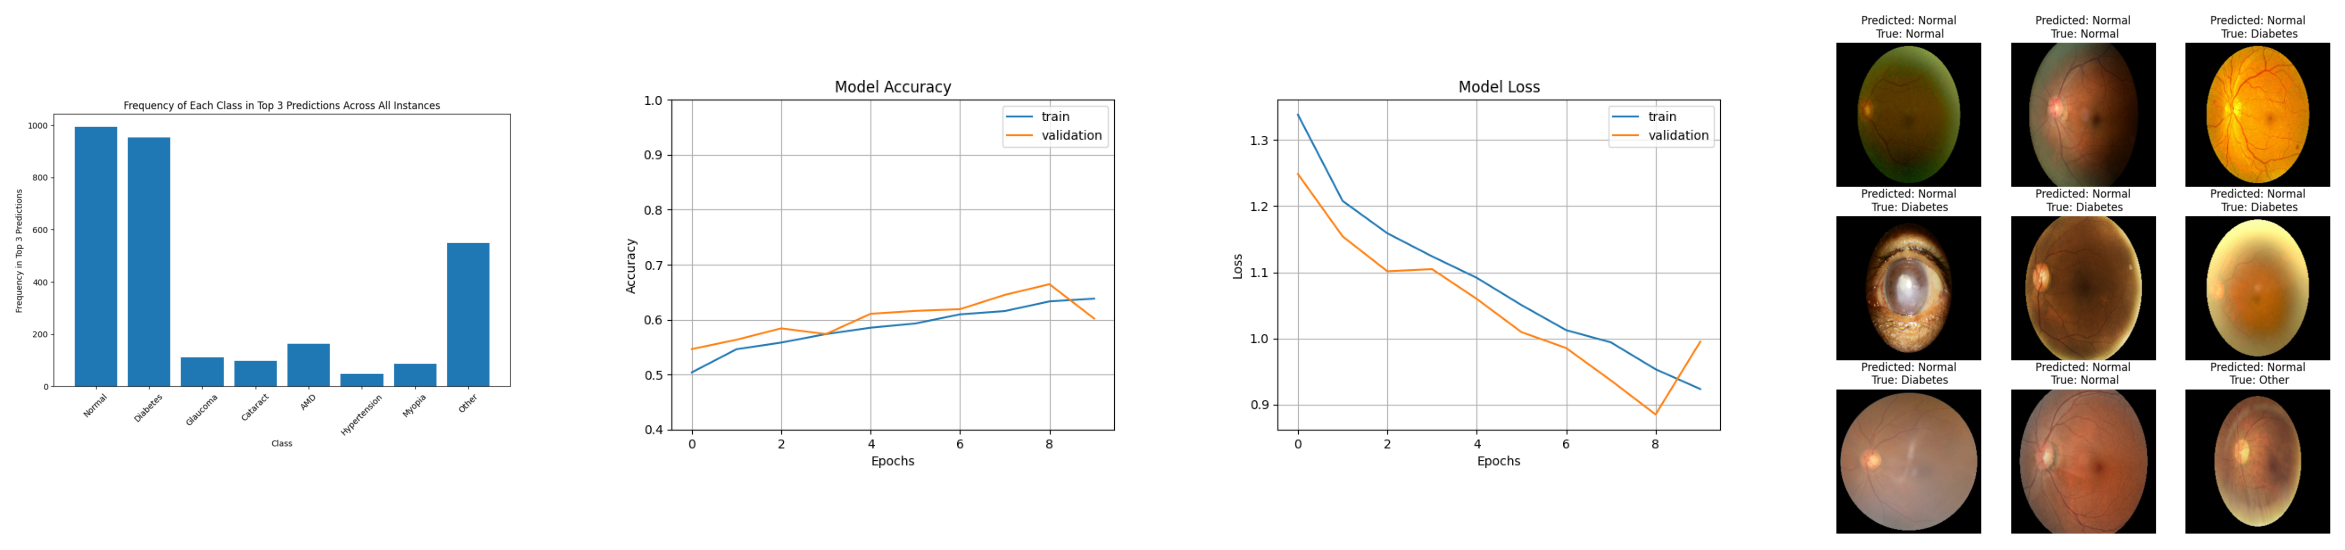

In [3]:
fig, axs = plt.subplots(1, 4, figsize=(30,10))

pred_graph = plt.imread('results/top3pred.png')
axs[0].imshow(pred_graph)
axs[0].axis('off')

model_acc = plt.imread('results/modelacc.png')
axs[1].imshow(model_acc)
axs[1].axis('off')

model_loss = plt.imread('results/modelloss.png')
axs[2].imshow(model_loss)
axs[2].axis('off')

test_pred = plt.imread('results/testpred.png')
axs[3].imshow(test_pred)
axs[3].axis('off')

plt.show()

# Data Distribution
- Below is shown the distribution of images available for each different ocular condition. The different diseases are encoded into individual coloums as N (Normal), D (Diabetes), G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia), O (Other diseases/abnormalities). They have binary indicators 0 or 1 to specify the absence or presence of a condition. This is also know as one-hot encoding. Thus, the dataset structure indicates multiple labels per image, allowing for multi-label classifcation.

- Conditions G, C, A, H and M are minority classes since they have low image samples, causing class imbalance. 

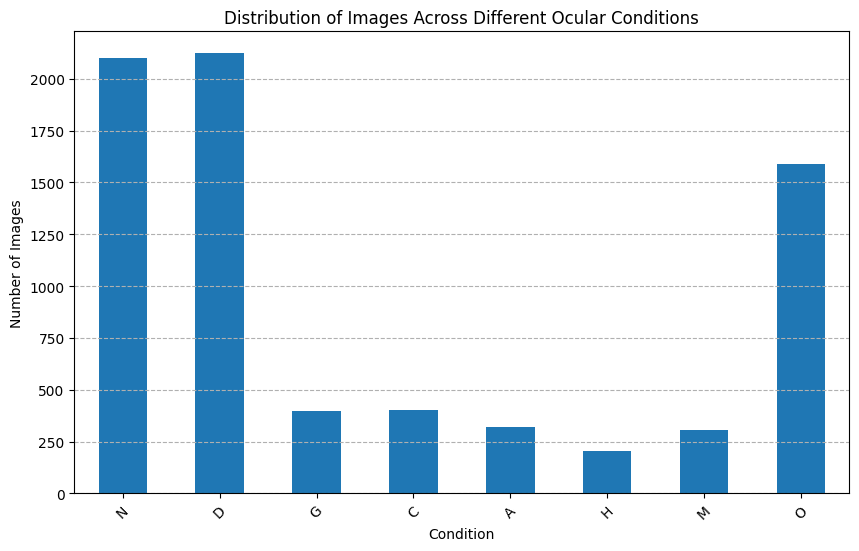

In [4]:
# Sum up the occurrences of each condition
class_counts = df_data[['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']].sum()

# Plotting
plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Images Across Different Ocular Conditions')
plt.xlabel('Condition')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')

plt.show()

In [46]:
class_distribution = df_data[['N','D','G', 'C', 'A', 'H', 'M', 'O']].sum()
print(class_distribution)

N    2101
D    2123
G     397
C     402
A     319
H     203
M     306
O    1588
dtype: int64


# Dealing with class imbalance - Data Augmentation 
- Data augmentation involves artificially increasing the size of your dataset by generating new data by resusing exisitng data, useful for underrepresented classes. Examples include rotations, flipping, noise, colour variations. 
- Will increase each minority class size to 2000 images by using the class counts and classes with less than 2000 images will be augmeneted to increase their size to 2000.
- The following minority classes should have their class sizes balanced -  G (Glaucoma), C (Cataract) , A (Age related Macular Degeneration), H (Hypertension), M (Pathological Myopia).

In [14]:
class_names = ['G', 'C', 'A', 'H', 'M', 'O']
images_path = 'dataset/ODIR-5K/Training Images/'

# Get initial class counts from the dataframe and filter classes with less than 2000 images
class_image_counts = df_data[class_names].sum()
classes_to_augment = class_image_counts[class_image_counts < 2000].index.tolist()

# Define the image augmentation generator
augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255 
)

def load_process_minority_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img, label
    return None, None


# Define the path where augmented images will be saved
augmented_images_path = 'dataset/minority_images/'

# Create directories for each class if they don't already exist
for cls in class_names:
    class_dir = os.path.join(augmented_images_path, cls)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

# Update the handle_minority_image_result function to save images
def handle_minority_image_result(result, image_counter):
    img, label = result
    if img is not None and label is not None:
        for i, cls in enumerate(classes_to_augment):
            index = class_names.index(cls)  # Get the index of the class in the label list
            if label[index] == 1 and class_image_counts[cls] < 2000:
                augmentations_needed = min(2000 - class_image_counts[cls], 5)
                for _ in range(augmentations_needed):
                    augmented_img = augmentation.random_transform(img)
                    # Save the augmented image to the corresponding class directory
                    save_path = os.path.join(augmented_images_path, cls, f"augmented_{image_counter[cls]}.png")
                    tf.keras.preprocessing.image.save_img(save_path, augmented_img)
                    image_counter[cls] += 1
                    class_image_counts[cls] += 1
                    if class_image_counts[cls] >= 2000:
                        break

# Initialize an image counter for naming images
image_counter = {cls: 0 for cls in classes_to_augment}

# No need to collect images in lists anymore, so the rest of the code is adapted to this change
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in tqdm(df_data.iterrows(), total=df_data.shape[0], desc='Processing images'):
        label = eval(row['target'])  # Assuming 'target' is a string representation of the list
        for cls in classes_to_augment:
            index = class_names.index(cls)
            if label[index] == 1:
                for eye in ['Left-Fundus', 'Right-Fundus']:
                    if row[eye]:  # Assuming non-empty strings evaluate to True
                        image_path = os.path.join(images_path, row[eye])
                        futures.append(executor.submit(load_process_minority_image, image_path, label))

    # Apply augmentation and save images
    for future in tqdm(futures, desc='Applying augmentation and saving images'):
        handle_minority_image_result(future.result(), image_counter)

# Since images are saved to disk, there's no need to convert them to NumPy arrays here.
# You can later load them directly from the disk when training your model.

print("Image counts per class after augmentation:")
for cls in classes_to_augment:
    print(f"{cls}: {class_image_counts[cls]}")


Processing images:   0%|          | 0/6392 [00:00<?, ?it/s]

Applying augmentation and saving images:   0%|          | 0/10904 [00:00<?, ?it/s]

Image counts per class after augmentation:
G: 2000
C: 2000
A: 2000
H: 2000
M: 2000
O: 2000


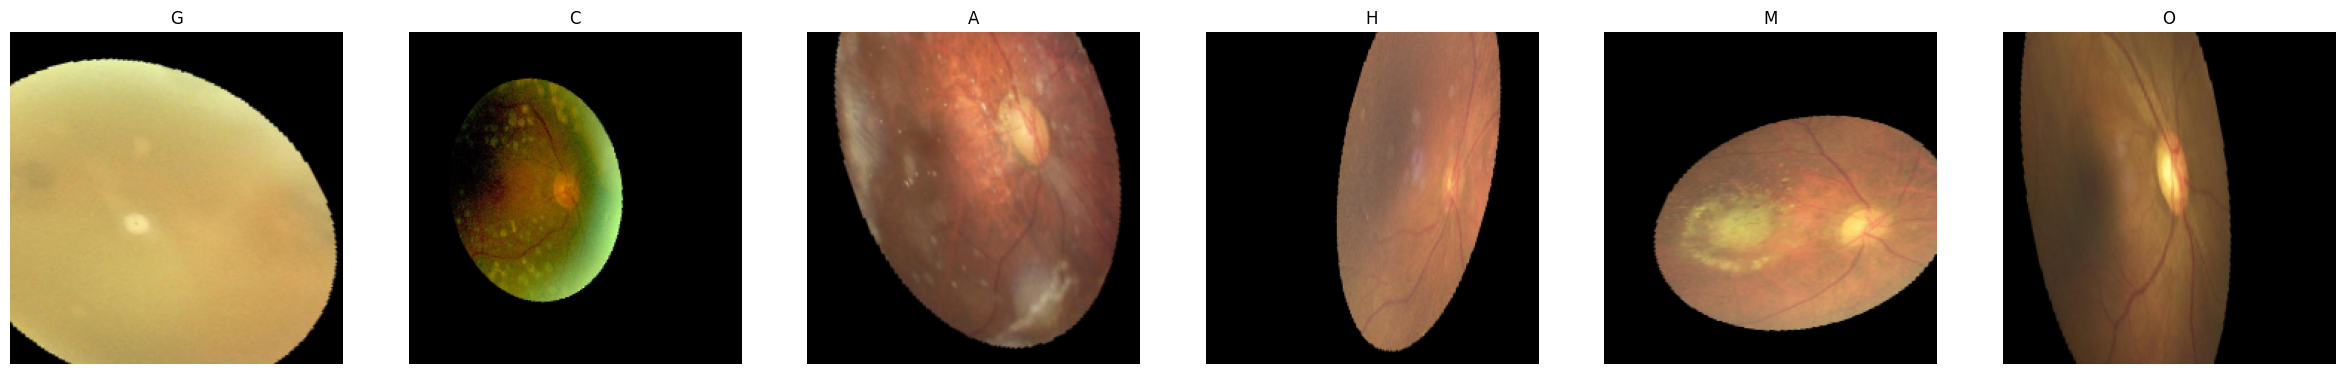

In [15]:
#plot the images
fig, axs = plt.subplots(1, 6, figsize=(30,10))

for i, cls in enumerate(class_names):
    img_path = os.path.join(augmented_images_path, cls, f"augmented_0.png")
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(cls)
    axs[i].axis('off')
    
plt.show()

# Loading minority data into memory 

In [ ]:
# Define the class names and the images path
class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
images_path = 'dataset/ODIR-5K/Training Images/'

# Get initial class counts from the dataframe and filter classes with less than 2000 images
class_image_counts = df_data[class_names].sum()
classes_to_augment = class_image_counts[class_image_counts < 2000].index.tolist()

# Define the image augmentation generator
augmentation = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.5,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    rescale=1./255 
)

# Initialize dictionaries to store the images and labels
minority_images = []
minority_labels = []

def load_process_minority_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img, label
    return None, None


# Modify handle_minority_image_result to work with the updated label fetching
def handle_minority_image_result(result):
    img, label = result
    if img is not None and label is not None:
        for i, cls in enumerate(classes_to_augment):
            index = class_names.index(cls)  # Get the index of the class in the label list
            if label[index] == 1 and class_image_counts[cls] < 2000:
                augmentations_needed = min(2000 - class_image_counts[cls], 5)
                for _ in range(augmentations_needed):
                    augmented_img = augmentation.random_transform(img)
                    minority_images.append(augmented_img)
                    minority_labels.append(label)
                    class_image_counts[cls] += 1
                    if class_image_counts[cls] >= 2000:
                        break

# Update the initialization part for ThreadPoolExecutor to use 'target' directly
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in tqdm(df_data.iterrows(), total=df_data.shape[0], desc='Processing images'):
        label = eval(row['target'])  # Convert the string representation of the list back to a list
        for cls in classes_to_augment:
            index = class_names.index(cls)
            if label[index] == 1:
                for eye in ['Left-Fundus', 'Right-Fundus']:
                    if row[eye]:  # Assuming non-empty strings evaluate to True
                        image_path = os.path.join(images_path, row[eye])
                        futures.append(executor.submit(load_process_minority_image, image_path, label))

    # Collecting results and applying augmentation
    for future in tqdm(futures, desc='Collecting results'):
        handle_minority_image_result(future.result())

# Convert to NumPy arrays
minority_images = np.array(minority_images)
minority_labels = np.array(minority_labels)

# Print out the class counts to verify
print("Image counts per class after augmentation:")
for cls in classes_to_augment:
    print(f"{cls}: {class_image_counts[cls]}")

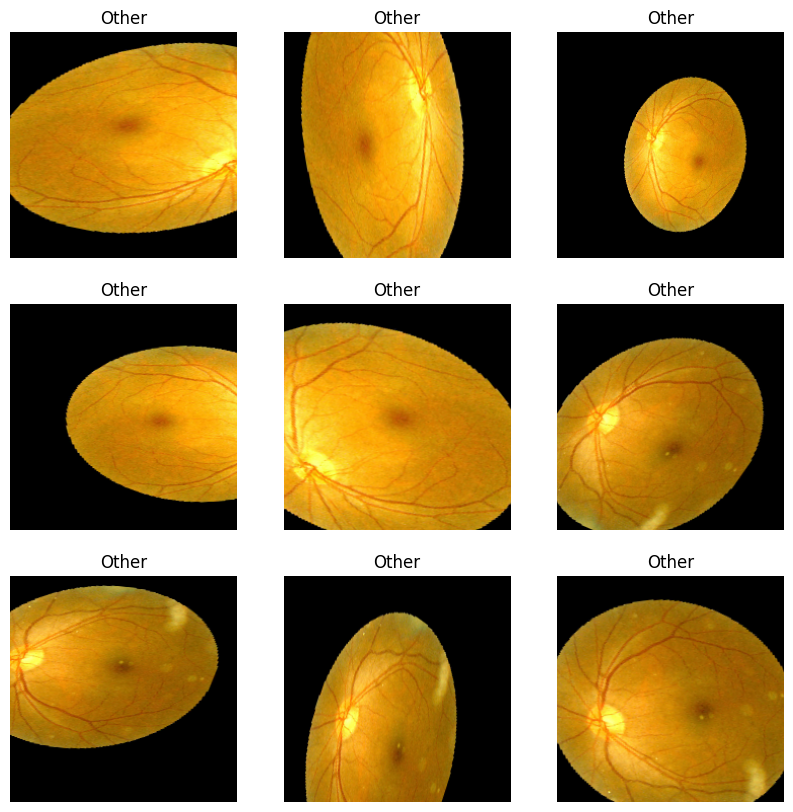

In [77]:
plt.figure(figsize=(10,10))
string_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
for i in range(9):
    plt.subplot(3,3, i + 1)
    plt.imshow(minority_images[i].astype('uint8'))
    plt.title(string_labels[np.argmax(minority_labels[i])])
    #plt.title(minority_labels[i])
    plt.axis('off')

plt.show()

# Loading and Visualising the majority classes 

In [3]:
# Directory where processed images will be saved
processed_images_dir = 'dataset/majority_images/'
if not os.path.exists(processed_images_dir):
    os.makedirs(processed_images_dir)

images_path = 'dataset/ODIR-5K/Training Images/'
majority_classes = ['N', 'D']
# Optimized DataFrame filtering
mask = df_data[majority_classes].sum(axis=1) > 0
df_data_majority = df_data[mask]

In [28]:


# Directory where processed images will be saved
processed_images_dir = 'dataset/majority_images/'
if not os.path.exists(processed_images_dir):
    os.makedirs(processed_images_dir)

# Define the path to the original images
images_path = 'dataset/ODIR-5K/Training Images/'

# Majority classes
majority_classes = ['N', 'D']

# Set to track processed images to avoid duplication
processed_images_set = set()

def save_processed_image(row, images_path, processed_images_dir, majority_classes, processed_images_set):
    for eye in ['Left-Fundus', 'Right-Fundus']:
        if row[eye]:  # Check if the image path is not empty
            file_path = os.path.join(images_path, row[eye])
            img_name = os.path.basename(file_path)
            
            # Check if image has already been processed to avoid duplication
            if img_name in processed_images_set:
                continue  # Skip this image if it has already been processed
            
            if os.path.exists(file_path):
                img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
                img_array = tf.keras.preprocessing.image.img_to_array(img)
                # Determine class from row and select folder
                for cls in majority_classes:
                    if row[cls] == 1:
                        class_dir = os.path.join(processed_images_dir, cls)
                        if not os.path.exists(class_dir):
                            os.makedirs(class_dir)
                        # Save image
                        save_file_path = os.path.join(class_dir, img_name)
                        if not os.path.exists(save_file_path):  # Check if the file already exists
                            tf.keras.preprocessing.image.save_img(save_file_path, img_array)
                            processed_images_set.add(img_name)  # Mark this image as processed
                        break  # Once saved in one class, no need to check other classes


# Use ThreadPoolExecutor to process images in parallel
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = [executor.submit(save_processed_image, row, images_path, processed_images_dir, majority_classes, processed_images_set) 
               for _, row in df_data_majority.iterrows()]

# Wait for all futures to complete if necessary
# It's optional to track the progress. Uncomment the next line if you want to see the progress.
[future.result() for future in tqdm(futures, desc='Processing & Saving Images')]

print("All relevant images processed and saved.")





Processing & Saving Images:   0%|          | 0/4224 [00:00<?, ?it/s]

All relevant images processed and saved.


In [30]:
#count the number of images in each class
class_counts = df_data_majority[majority_classes].sum()
print(class_counts)

N    2101
D    2123
dtype: int64


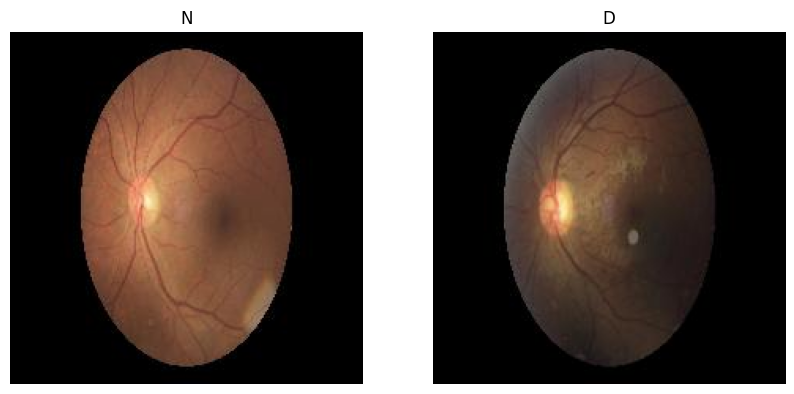

In [29]:
# Plot the images
fig, axs = plt.subplots(1, 2, figsize=(10,10))

for i, cls in enumerate(majority_classes):
    img_path = os.path.join(processed_images_dir, cls, f"{os.listdir(processed_images_dir + cls)[0]}")
    img = plt.imread(img_path)
    axs[i].imshow(img)
    axs[i].set_title(cls)
    axs[i].axis('off')
    
plt.show()


# Loading majority data into memory 

In [ ]:
# Define the class names and the images path
class_names = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']
images_path = 'dataset/ODIR-5K/Training Images/'

# Get initial class counts from the dataframe and filter classes with less than 2000 images
class_image_counts = df_data[class_names].sum()
classes_to_augment = class_image_counts[class_image_counts > 2000].index.tolist()


# Initialize dictionaries to store the images and labels
majority_images = []
majority_labels = []

def load_process_minority_image(file_path, label):
    if os.path.exists(file_path):
        img = tf.keras.preprocessing.image.load_img(file_path, target_size=(224, 224))
        img = tf.keras.preprocessing.image.img_to_array(img)
        return img, label
    return None, None


def handle_majority_image_result(result):
    img, label = result
    if img is not None and label is not None:
        for i, cls in enumerate(classes_to_augment):
            index = class_names.index(cls)  # Get the index of the class in the label list
            if label[index] == 1 and class_image_counts[cls] > 2000:
                majority_images.append(img)
                majority_labels.append(label)
        
# Update the initialization part for ThreadPoolExecutor to use 'target' directly
with ThreadPoolExecutor(max_workers=8) as executor:
    futures = []
    for _, row in tqdm(df_data.iterrows(), total=df_data.shape[0], desc='Processing images'):
        label = eval(row['target'])  # Convert the string representation of the list back to a list
        for cls in classes_to_augment:
            index = class_names.index(cls)
            if label[index] == 1:
                for eye in ['Left-Fundus', 'Right-Fundus']:
                    if row[eye]:  # Assuming non-empty strings evaluate to True
                        image_path = os.path.join(images_path, row[eye])
                        futures.append(executor.submit(load_process_minority_image, image_path, label))

    # Collecting results and applying augmentation
    for future in tqdm(futures, desc='Collecting results'):
        handle_majority_image_result(future.result())
        
# Convert to NumPy arrays
majority_images = np.array(majority_images)
majority_labels = np.array(majority_labels)

# Print out the class counts to verify
print("Image counts per class:")
for cls in classes_to_augment:
    print(f"{cls}: {class_image_counts[cls]}")
    

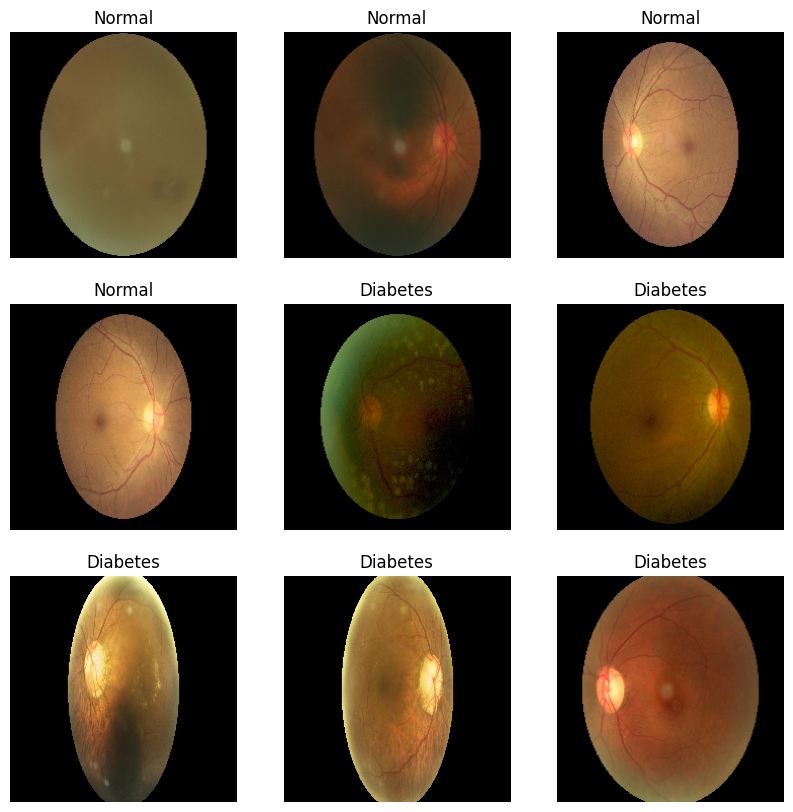

In [80]:
# Plot the images
plt.figure(figsize=(10,10))
string_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(majority_images[i].astype('uint8'))
    plt.title(string_labels[np.argmax(majority_labels[i])])
    #plt.title(majority_labels[i])
    plt.axis('off')
    

# Joining the minority and majority images

In [ ]:
minority_classes = ['G', 'C', 'A', 'H', 'M']
majority_classes = ['N', 'D','O']

In [ ]:
def load_images_and_labels_from_directories(directories, class_names):
    images = []
    labels = []
    for dir_path in directories:
        for class_name in class_names:
            class_dir = os.path.join(dir_path, class_name)
            if not os.path.exists(class_dir):
                continue
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                img = load_img(img_path, target_size=(224, 224))
                img = img_to_array(img)
                img = img / 255.0  # Normalize to [0, 1]
                images.append(img)
                labels.append(class_names.index(class_name))  # Convert class name to index

    return np.array(images), to_categorical(np.array(labels), num_classes=len(class_names))

# Define directories
majority_dir = 'dataset/majority_images/'
minority_dir = 'dataset/minority_images/'

# Assuming majority_classes and minority_classes are defined as before
all_classes = majority_classes + [cls for cls in minority_classes if cls not in majority_classes]

# Load images and labels
majority_images, majority_labels = load_images_and_labels_from_directories([majority_dir], all_classes)
minority_images, minority_labels = load_images_and_labels_from_directories([minority_dir], all_classes)

# Combine datasets
combined_images = np.concatenate((majority_images, minority_images), axis=0)
combined_labels = np.concatenate((majority_labels, minority_labels), axis=0)



In [84]:
# join the minority and majority images and labels
def image_label_generator(minority_images, minority_labels, majority_images, majority_labels):
    # Assuming minority and majority arrays are paths or identifiers to load images
    for image_array, label_array in zip([minority_images, majority_images], [minority_labels, majority_labels]):
        for image, label in zip(image_array, label_array):
            # Load your image here, e.g., using tf.keras.preprocessing.image.load_img
            # and then convert it to an array
            yield image, label

# Create a dataset from the generator
dataset = tf.data.Dataset.from_generator(
    lambda: image_label_generator(minority_images, minority_labels, majority_images, majority_labels),
    output_types=(tf.float32, tf.int32),
    output_shapes=((224, 224, 3), (len(class_names),))
)

# Apply batching, shuffling, etc.
dataset = dataset.shuffle(buffer_size=1024).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = int(0.2 * len(dataset))

Preparing augmentated data for training
- Splitting the augmented minority data into training and validation sets. 

In [24]:

# Create a tf.data.Dataset
image_ds = tf.data.Dataset.from_tensor_slices((images, labels))

# Shuffle the dataset
image_ds = image_ds.shuffle(buffer_size=len(images))

# Split the dataset into training and validation sets
train_size = int(0.8 * len(images))
train_ds = image_ds.take(train_size)
val_ds = image_ds.skip(train_size)

# Batch the datasets
batch_size = 16
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

# Prefetch the datasets
train_ds = train_ds.prefetch(tf.data.experimental.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.experimental.AUTOTUNE)


MemoryError: Unable to allocate 16.6 GiB for an array with shape (29592, 224, 224, 3) and data type float32

In [20]:
print("size of training dataset: ", len(train_ds))
print("size of validation dataset: ", len(val_ds))

TypeError: The dataset length is unknown.

Visualising Training and Validation Data 

Training dataset
(32, 224, 224, 3)
(32, 8)


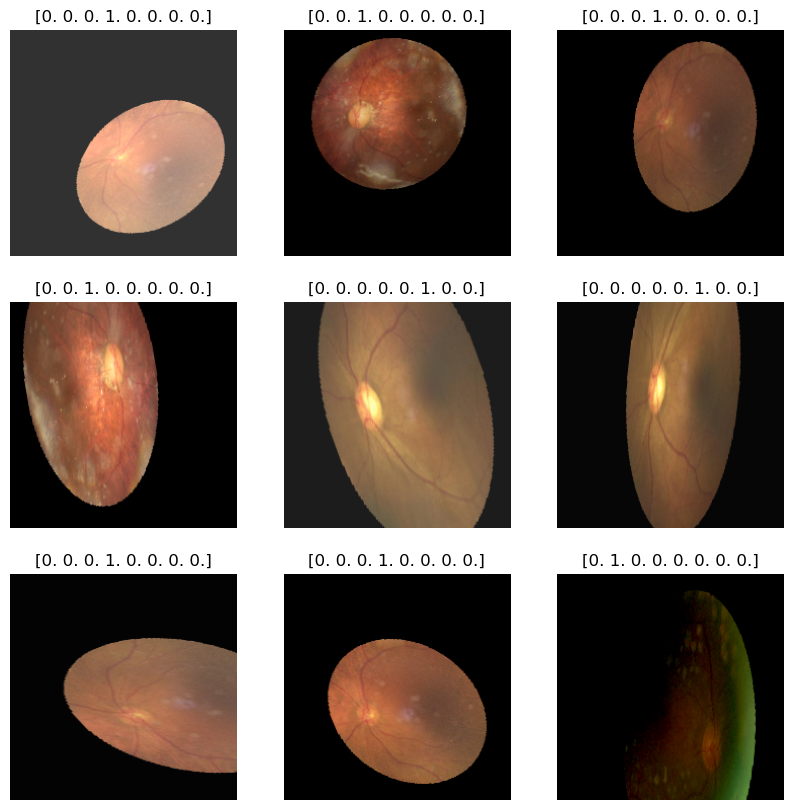

In [ ]:
print("Training dataset")
for images, labels in train_dataset.take(1):
    print(images.shape)
    print(labels.shape)


# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[i].numpy())
    plt.axis("off")

Validation dataset
(32, 224, 224, 3)
(32, 8)


c:\Users\duwak\anaconda3\Lib\site-packages\matplotlib\text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


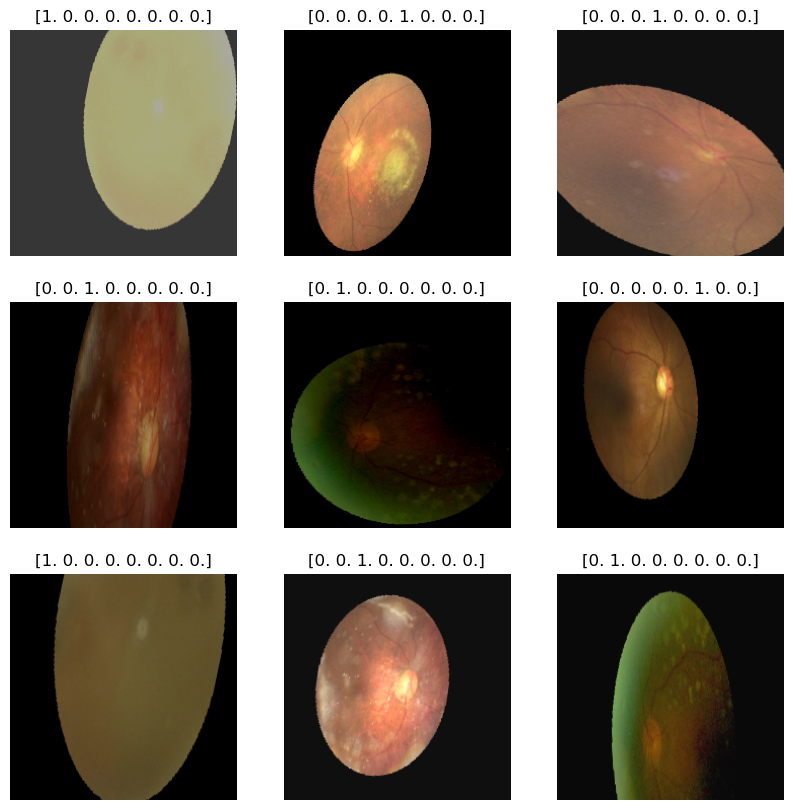

In [ ]:
print("Validation dataset")
for images, labels in val_dataset.take(1):
    print(images.shape)
    print(labels.shape)
# Plotting the first 9 images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[i].numpy())
    plt.axis("off")

Training the model

In [ ]:
resnet_50_model = Sequential()

pretrained_model = tf.keras.applications.ResNet50(
    include_top=False,
    input_shape=(224, 224, 3),
    pooling='avg', classes=8,
    weights='imagenet')

for layer in pretrained_model.layers:
    layer.trainable = False

resnet_50_model.add(pretrained_model)
resnet_50_model.add(Flatten())
resnet_50_model.add(Dense(512, activation='relu'))
resnet_50_model.add(Dense(8, activation='softmax'))



# Early Stopping 
- This is implemented to prevent overfitting if the validation loss begins to rise consisenly as training goes on. 

In [ ]:
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2

# Add dropout and regularization to the model
resnet_50_model.add(Dropout(0.5))  # Add dropout after the Flatten layer
resnet_50_model.add(Dense(512, activation='relu', kernel_regularizer=l2(0.001)))

In [ ]:
resnet_50_model.summary()

In [ ]:
resnet_50_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
epochs = 10
history = resnet_50_model.fit(train_dataset, validation_data=val_dataset, epochs=epochs)

Evaluating Model 

In [ ]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

Loading Test Data 

In [ ]:
def parse_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)

    return image

In [ ]:
from pathlib import Path


data_dir = Path('dataset/ODIR-5K/')
test_dataset = list(data_dir.glob('Testing Images/*'))


test_dataset = [str(path) for path in test_dataset]
test_dataset = tf.data.Dataset.from_tensor_slices(test_dataset)
test_dataset = test_dataset.map(parse_image)


# Now you can batch, shuffle, and prefetch the dataset as needed
test_dataset = test_dataset.batch(32)  # batching
test_dataset = test_dataset.prefetch(tf.data.experimental.AUTOTUNE)  # prefetching


# Visualize the data
plt.figure(figsize=(10,10))

for i, image in enumerate(test_dataset.take(4)):
    ax = plt.subplot(2,2,i+1)
    plt.imshow(image[0] / 255)
    plt.axis('off')



In [ ]:
print("size of test dataset: ", len(test_dataset))    

Making Predictions


In [ ]:
# Evaluate the model on the test dataset
resnet_50_model.evaluate(test_dataset)

predictions = resnet_50_model.predict(test_dataset)

# Get the predicted classes
predicted_classes = np.argmax(predictions, axis=1)

# Plot the first 9 images, their predicted labels, and the true labels
output_class=class_labels[np.argmax(predicted_classes[i])]
plt.figure(figsize=(10, 10))

for i, image in enumerate(test_dataset.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image[0] / 255)
    plt.title("Predicted: {}\n True: {}".format(output_class, class_labels[np.argmax(labels[i])]))
    plt.axis("off")

In [ ]:

# Get the class with the highest probability
pred_class = np.argmax(pred)
print(pred_class)

# Get the class labels
class_labels = ['Normal', 'Diabetes', 'Glaucoma', 'Cataract', 'AMD', 'Hypertension', 'Myopia', 'Other']
class_labels[pred_class]

# Get the top 3 class labels
top3_class_indices = pred[0].argsort()[-3:][::-1]
top3_class_indices

# Get the top 3 class labels
top3_class_labels = [class_labels[i] for i in top3_class_indices]
top3_class_labels

# Get the top 3 class probabilities
top3_class_probabilities = pred[0][top3_class_indices]
top3_class_probabilities

# Visualize the top 3 class labels and their probabilities
plt.bar(top3_class_labels, top3_class_probabilities)
plt.ylabel('Probability')
plt.xlabel('Class')
plt.title('Top 3 Predictions')
plt.show()

In [ ]:
# Save the model
resnet_50_model.save('resnet_50_model')